In [59]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import cv2
import random

In [60]:
from google.colab import drive
drive.mount('/content/drive')
dataset = "/content/drive/MyDrive/Colab Notebooks/animal_dataset"
animals = os.listdir(dataset)
print(animals)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['cat', 'panda', 'dog']


In [61]:
classes= ["cat", "dog", "panda"]

img_size = (32, 32)
random.seed(42)
np.random.seed(42)

In [62]:
def load_dataset(dataset, classes, img_size):
    data = []
    labels = []

    for label, cls in enumerate(classes):
        class_folder = os.path.join(dataset, cls)

        if not os.path.isdir(class_folder):
            print(f"folder not found → {class_folder}")
            continue

        for file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file)

            img = cv2.imread(img_path)
            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, img_size)

            data.append(gray.flatten().astype(np.float32))
            labels.append(label)

    data = np.array(data) / 255.0
    labels = np.array(labels)

    return data, labels

In [63]:
data, labels = load_dataset(dataset, classes, img_size)
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (300, 1024)
Labels shape: (300,)


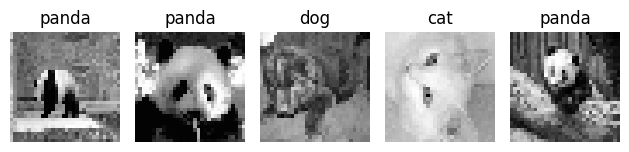

In [64]:
n = 5
x = np.random.choice(len(data), n, replace=False)

for i, idx in enumerate(x):
    img = (data[idx].reshape(32, 32) * 255).astype(np.uint8)

    plt.subplot(1, n, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(classes[labels[idx]])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [65]:
def l1_distance(a, b):
    return np.sum(np.abs(a - b))

def l2_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [66]:
def pred_knn(train_X, train_y, x_test, k, dist_func):
    dists = []
    for i in range(len(train_X)):
        d = dist_func(train_X[i], x_test)
        dists.append((d, train_y[i]))

    dists.sort(key=lambda x: x[0])
    k_labels = [label for (_, label) in dists[:k]]

    return np.argmax(np.bincount(k_labels))

In [67]:
folds=5
def cross_validate(data, labels, k_values, dist_func, folds):
    n = len(data)
    indices = np.arange(n)
    np.random.shuffle(indices)

    fold_ind = np.array_split(indices, folds)
    acc_results = {k: [] for k in k_values}

    for fold in range(folds):
        test_idx     = fold_ind[fold]
        train_idx    = np.hstack([fold_ind[i] for i in range(folds) if i != fold])

        train_X, train_y = data[train_idx], labels[train_idx]
        test_X,  test_y  = data[test_idx],  labels[test_idx]

        for k in k_values:
            correct = 0
            for x, true in zip(test_X, test_y):
                pred = pred_knn(train_X, train_y, x, k, dist_func)
                if pred == true:
                    correct += 1

            acc = correct / len(test_y)
            acc_results[k].append(acc)
            print(f"Fold {fold+1}  K={k}  Average Accuracycc={acc:.4f}")

    avg_acc = {k: np.mean(acc_results[k]) for k in k_values}
    return avg_acc

In [68]:
k_values = [1, 3, 5, 7, 9, 11, 13]

print("(L1)")
acc_l1 = cross_validate(data, labels, k_values, l1_distance, folds)

print("\n(L2)")
acc_l2 = cross_validate(data, labels, k_values, l2_distance, folds)

(L1)
Fold 1  K=1  Average Accuracycc=0.3667
Fold 1  K=3  Average Accuracycc=0.4167
Fold 1  K=5  Average Accuracycc=0.4000
Fold 1  K=7  Average Accuracycc=0.4500
Fold 1  K=9  Average Accuracycc=0.4833
Fold 1  K=11  Average Accuracycc=0.4667
Fold 1  K=13  Average Accuracycc=0.4833
Fold 2  K=1  Average Accuracycc=0.4333
Fold 2  K=3  Average Accuracycc=0.4500
Fold 2  K=5  Average Accuracycc=0.3500
Fold 2  K=7  Average Accuracycc=0.3667
Fold 2  K=9  Average Accuracycc=0.4333
Fold 2  K=11  Average Accuracycc=0.4333
Fold 2  K=13  Average Accuracycc=0.3833
Fold 3  K=1  Average Accuracycc=0.3833
Fold 3  K=3  Average Accuracycc=0.3833
Fold 3  K=5  Average Accuracycc=0.4000
Fold 3  K=7  Average Accuracycc=0.4500
Fold 3  K=9  Average Accuracycc=0.4167
Fold 3  K=11  Average Accuracycc=0.4500
Fold 3  K=13  Average Accuracycc=0.4667
Fold 4  K=1  Average Accuracycc=0.2333
Fold 4  K=3  Average Accuracycc=0.3167
Fold 4  K=5  Average Accuracycc=0.3000
Fold 4  K=7  Average Accuracycc=0.3667
Fold 4  K=9  A

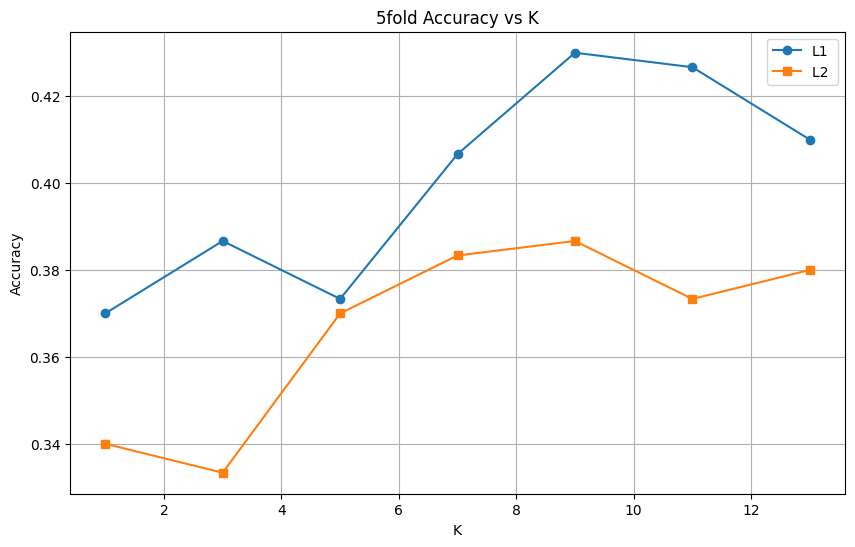

In [69]:
plt.figure(figsize=(10,6))
plt.plot(k_values, [acc_l1[k] for k in k_values], marker="o", label="L1")
plt.plot(k_values, [acc_l2[k] for k in k_values], marker="s", label="L2 ")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("5fold Accuracy vs K")
plt.grid(True)
plt.legend()
plt.show()

In [70]:
best_k_l1 = max(acc_l1, key=acc_l1.get)
best_k_l2 = max(acc_l2, key=acc_l2.get)

dist_func = l1_distance if acc_l1[best_k_l1] >= acc_l2[best_k_l2] else l2_distance
best_k    = best_k_l1 if dist_func == l1_distance else best_k_l2

print(f"\n  K={best_k} and distance={'L1' if dist_func== l1_distance else 'L2'} for best Pred")


  K=9 and distance=L1 for best Pred


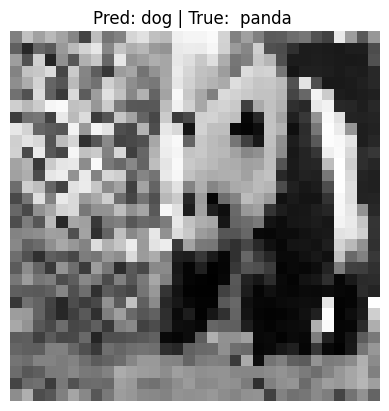

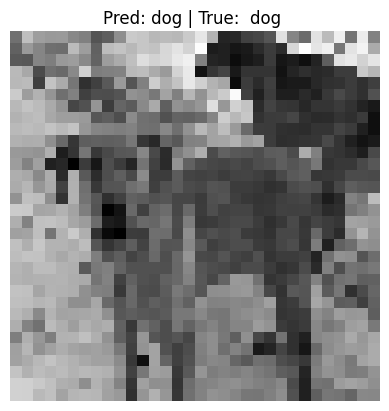

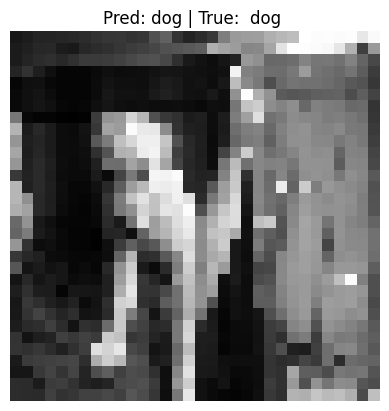

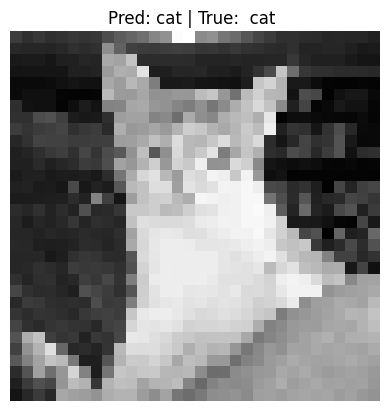

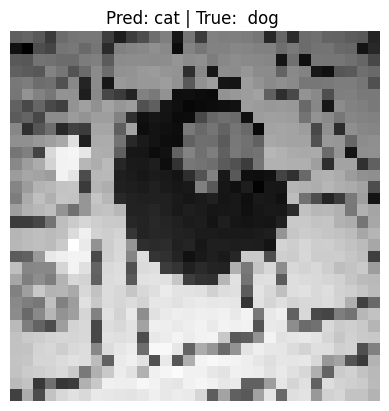

In [71]:
idxs = np.random.choice(len(data), 5, replace=False)

for i in idxs:
    img = (data[i].reshape(32,32) * 255).astype(np.uint8)
    pred = pred_knn(data, labels, data[i], k=best_k, dist_func=dist_func)

    plt.figure()
    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {classes[pred]} | True:  {classes[labels[i]]} ")
    plt.axis("off")
    plt.show()